## Installing & Loading Packages

In [1]:
!pip install opencv-python pytesseract
!apt install tesseract-ocr
!apt install libtesseract-dev
!pip install colormath

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 24 not upgraded.
Need to get 4,850 kB of archives.
After this operation, 16.3 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1 [1,598 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal/universe amd64 tesseract-ocr amd64 4.1.1-2build2 [262 kB]
Fetched 4,850 kB in 0s (10.7 MB/s)
Selecting previously unselected package tesseract-ocr-eng.
(Reading database ..

In [2]:
import copy
import numpy as np
import scipy.stats as sts
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import matplotlib
import cv2
import random
from google.colab import files
import pytesseract
from colormath.color_objects import sRGBColor, LabColor
from colormath.color_conversions import convert_color
from colormath.color_diff import delta_e_cie2000
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


## Flood Simulation Code

In [3]:
# code is adapted from CS166, session 9
class FloodingSimulation:
    """
    A class representing a simulation of flooding.

    Attributes
    ----------
    dem : numpy.ndarray
        An array of elevation data representing the Digital Elevation Model (DEM) 
        for the simulation.
    infiltration_rate : float
        The rate at which water infiltrates into the ground.
    groundwater_rate : float
        The rate at which infiltrated water flows through the ground.
    timestep_size : float
        The duration of each simulation timestep.
    infiltration_max : float
        The maximum amount of water that can infiltrate into the ground at a single 
        timestep.
    min_flooded : float
        The minimum water level needed to consider a cell as flooded.
    x : int
        The number of rows in the DEM grid.
    y : int
        The number of columns in the DEM grid.
    water_level : numpy.ndarray
        An array representing the water level in each cell of the DEM grid.
    water_level_next : numpy.ndarray
        An array representing the water level in each cell of the DEM grid in the next 
        timestep.
    infiltration_level : numpy.ndarray
        An array representing the infiltration level in each cell of the DEM grid.
    flooded : numpy.ndarray
        An array representing whether each cell of the DEM grid is flooded.
    timestep : int
        The current timestep of the simulation.
    flooded_over_time : list
        A list representing the proportion of cells that are flooded at each timestep.
    drainage_basins : numpy.ndarray
        An array representing whether each cell of the DEM grid is a drainage basin.
    wall : numpy.ndarray
        An array representing whether each cell of the DEM grid is part of a wall.

    Methods
    -------
    rain(region_x, region_y, rain_dist)
        Simulates rainfall in a specific region of the DEM grid.
    random_rain(proportion_spread, rain_dist)
        Simulate rainfall randomly across the entire DEM grid.
    add_drainage_basins(proportion)
        Add drainage basins to the DEM grid.
    add_wall(range_x, range_y)
        Add a wall to the DEM grid.
    update()
        Updates the water level in each cell of the DEM grid based on infiltration, 
        groundwater flow, and water dispersion.
    neighbours(i, j)
        Returns the indices of neighbouring cells.
    observe(layer)
        Visualises the state of the simulation based on the specified layer.
    animate(step, layer)
        Advances the simulation by one step and visualises the new state based on the 
        specified layer.
    animate_rain(step, region_x, region_y, rain_dist, layer)
        Advances the simulation by one step, makes it rain across the entire grid and 
        visualises the new state based on the specified layer
    """

    def __init__(self, dem, infiltration_rate, groundwater_rate, 
                 timestep_size = 1, infiltration_max = 5, min_flooded = 1, 
                 surpress_axis = False):
        """
        Initialise a FloodingSimulation object.

        Parameters
        ----------
        dem : numpy.ndarray
            An array of elevation data representing the Digital Elevation Model 
            (DEM) for the simulation.
        infiltration_rate : float
            The rate at which water infiltrates into the ground.
        groundwater_rate : float
            The rate at which infiltrated water flows through the ground.
        timestep_size : float, optional
            The duration of each simulation timestep. Default is 1.
        infiltration_max : float, optional
            The maximum amount of water that can infiltrate into the ground at a single timestep. 
            Default is 5.
        min_flooded : float, optional
            The minimum water level needed to consider a cell as flooded. Default is 1.
        suppress_axis : bool, optional
            Whether to suppress the creation of the plot axes. Default is False.

        Returns
        -------
        None
        """
        self.dem = copy.deepcopy(dem)
        self.infiltration_rate = infiltration_rate
        self.groundwater_rate = groundwater_rate
        self.timestep_size = timestep_size
        self.infiltration_max = infiltration_max
        self.min_flooded = min_flooded
        self.x = self.dem.shape[0]
        self.y = self.dem.shape[1]
        self.water_level = np.zeros((self.x, self.y))
        self.water_level_next = np.zeros((self.x, self.y))
        self.infiltration_level = np.zeros((self.x, self.y))
        self.flooded = np.zeros((self.x, self.y), dtype=bool)
        self.timestep = 0
        self.flooded_over_time = []
        self.drainage_basins = np.zeros((self.x, self.y))
        self.wall = np.zeros((self.x, self.y))

        # control when axis is created
        if surpress_axis == False:
            self.figure, self.axes = plt.subplots(figsize = (10, 8))

    def rain(self, region_x, region_y, rain_dist):
        """
        Simulates rainfall in a specific region of the DEM grid.

        Parameters
        ----------
        region_x : tuple of ints
            The range of row indices representing the region in which rainfall is simulated.
        region_y : tuple of ints
            The range of column indices representing the region in which rainfall is simulated.
        rain_dist : scipy.stats.rv_continuous
            The continuous random variable representing the probability distribution of 
            rainfall intensity.

        Returns
        -------
        None
        """
        for i in range(region_x[0], region_x[1]):
            for j in range(region_y[0], region_y[1]):

                # add a random amount of rain to each cell
                self.water_level[i, j] += rain_dist.rvs()

    def random_rain(self, proportion_spread, rain_dist):
        """
        Simulate rainfall randomly across the entire DEM grid. The amount of cells that
        receive rain is proportion to proportion_spread.

        Parameters
        ----------
        proportion_spread : float
            The proportion of cells to be affected by the rainfall.
        rain_dist : scipy.stats.rv_continuous
            The continuous random variable representing the probability distribution of 
            rainfall intensity.

        Returns
        -------
        None
        """
        for i in range(self.x):
            for j in range(self.y):
                if random.random() < proportion_spread:

                    # add a random amount of rain to each chosen cell
                    self.water_level[i, j] += rain_dist.rvs()

        self.flooded = self.water_level > self.min_flooded
        self.flooded_over_time.append(np.sum(self.flooded)/(self.x*self.y))

    def add_drainage_basins(self, proportion):
        """
        Add drainage basins to the DEM grid.

        Parameters
        ----------
        proportion : float
            The proportion of cells to be converted into drainage basins.

        Returns
        -------
        None
        """
        for i in range(self.x):
            for j in range(self.y):
                if random.random() < proportion:

                    # if there is a drainage basin, set elevation to 0
                    self.drainage_basins[i, j] = 1
                    self.dem[i, j] = 0

    def add_wall(self, range_x, range_y):
        """
        Add a wall to the DEM grid.

        Parameters
        ----------
        range_x : tuple of ints
            The range of row indices representing the wall location.
        range_y : tuple of ints
            The range of column indices representing the wall location.

        Returns
        -------
        None
        """
        for i in range_x:
            for j in range_y:

                # if there is a wall, set elevation to be high
                self.wall[i, j] = 1
                self.dem[i, j] = 300

    def update(self):
        """
        Updates the water level in each cell of the DEM grid based on infiltration, groundwater 
        flow, and water dispersion. The cells are updated synchronously using a grid containing 
        the next water levels for each cell.
        The basic steps of this algorithm are as follows:
        1. Iterate over the cells in the CA.
        2. Water that has already infiltrated the ground can leave as groundwater flow.
        3. Surface water can infiltrate if the maximum infiltration is not reached.
        4. Surface water left is dispersed to neighbours that have lower elevation 
        (proportional to the elevation loss).

        Parameters
        ----------
        None

        Returns
        -------
        None
        """
        self.water_level_next = copy.deepcopy(self.water_level)

        for i in range(1, self.x-1):
            for j in range(1, self.y-1):

                # infiltrated water leaves at groundwater flow rate
                if self.infiltration_level[i, j] > 0:
                    groundwater = self.groundwater_rate * self.timestep_size
                    self.infiltration_level[i, j] -= min(groundwater, self.infiltration_level[i, j])

                # if there is water in the cell
                if self.water_level[i, j] > 0:
                    # water can infiltrate first
                    infiltration = self.infiltration_rate * self.timestep_size
                    infiltration = min(infiltration, self.water_level[i, j])

                    # if the maximum amount of water can infiltrate
                    if infiltration + self.infiltration_level[i, j] <= self.infiltration_max:
                        self.infiltration_level[i, j] += infiltration
                        self.water_level_next[i, j] -= infiltration

                    # otherwise infiltrate as much as possible
                    else:
                        infiltration = self.infiltration_max - self.infiltration_level[i, j]
                        self.infiltration_level[i, j] += infiltration
                        self.water_level_next[i, j] -= infiltration

                # create list of neighbours with lower elevation
                elevation_loss_neighbours = []
                elevation_loss_amounts = []
                for ni, nj in self.neighbours(i, j):
                    if self.dem[ni, nj] < self.dem[i, j]:
                        elevation_loss_neighbours.append((ni, nj))
                        elevation_loss_amounts.append(self.dem[i, j] - self.dem[ni, nj])

                # disperse water based on proportion related to elevation loss
                total_elevation_loss = sum(elevation_loss_amounts)
                for idx, n in enumerate(elevation_loss_neighbours):
                    prop_water = self.water_level[i, j] * elevation_loss_amounts[idx] / total_elevation_loss
                    self.water_level_next[n[0], n[1]] += prop_water
                
                if len(elevation_loss_neighbours) > 0:
                    self.water_level_next[i, j] -= self.water_level[i, j]
        
        self.flooded = self.water_level_next > self.min_flooded
        self.flooded_over_time.append(np.sum(self.flooded)/(self.x*self.y))
        self.water_level = copy.deepcopy(self.water_level_next)
        self.timestep += 1

    def neighbours(self, i, j):
        """
        Returns the indices of neighbouring cells.

        Parameters
        -----------
        i : int
            The row index of the current cell.
        j : int
            The column index of the current cell.

        Returns
        --------
        list
            The indices of neighbouring cells of the current cell.
        """
        # get indices of neighbours of a cell
        return [(i-1, j), (i, j+1), (i+1, j), (i, j-1),
                (i-1, j-1), (i-1, j+1), (i+1, j-1), (i+1, j+1)]

    def observe(self, layer):
        """
        Visualises the state of the simulation based on the specified layer.

        Parameters
        -----------
        layer : str
            The layer to visualise. Options are 'Water Level', 'Flooded Cells', 
            'Infiltration Level', and 'DEM'.

        Returns
        --------
        matplotlib.image.AxesImage:
            The plotted image of the simulation.
        """
        if layer == 'Water Level':
            grid = self.water_level
            vmin = 0
            vmax = 10
            cmap = 'Blues'
        elif layer == 'Flooded Cells':
            grid = self.flooded
            vmin = 0
            vmax = 1
            cmap = 'Blues'
        elif layer == 'Infiltration Level':
            grid = self.infiltration_level
            vmin = 0
            vmax = self.infiltration_max
            cmap = 'Blues'
        elif layer == 'DEM':
            grid = self.dem
            vmin = np.amin(grid)
            vmax = np.amax(grid)
            cmap = 'Oranges'
        else:
            return

        # remove fixed edges from grid (not updated in CA)
        grid = grid[1:self.x-1, 1:self.y-1]

        plot = self.axes.imshow(grid, vmin = vmin, vmax = vmax, cmap = cmap)
        self.axes.set_title(f'{layer} at Step {self.timestep}')
        return plot

    def animate(self, step, layer):
        """
        Advances the simulation by one step and visualises the new state based on the 
        specified layer.

        Parameters
        -----------
        step : int
            The current step of the simulation.
        layer : str
            The layer to visualise. Options are 'water_level', 'flooded_cells', 
            'infiltration_level', and 'dem'.

        Returns
        --------
        matplotlib.image.AxesImage
            The plotted image of the simulation.
        """
        self.update()
        return self.observe(layer)

    def animate_rain(self, step, region_x, region_y, rain_dist, layer):
        """
        Advances the simulation by one step and visualises the new state based on 
        the specified layer.

        Parameters
        -----------
        step : int
            The current step of the simulation.
        region_x : tuple of ints
            The range of row indices representing the region in which rainfall 
            is simulated.
        region_y : tuple of ints
            The range of column indices representing the region in which rainfall 
            is simulated.
        rain_dist : scipy.stats.rv_continuous
            The continuous random variable representing the probability distribution 
            of rainfall intensity.
        layer : str
            The layer to visualise. Options are 'water_level', 'flooded_cells', 
            'infiltration_level', and 'dem'.

        Returns
        --------
        matplotlib.image.AxesImage
            The plotted image of the simulation.
        """
        self.update()
        self.rain(region_x, region_y, rain_dist)
        return self.observe(layer)

## Testing the Simulation: Basic Examples

In [4]:
# code is adapted from CS166, session 6
def test(dem, rain_region = [[0, 49], [0, 49]], rain_dist = sts.uniform(3, 5), infiltration_rate = 1, 
         groundwater_rate = 0.5, infiltration_max = 5, min_flooded = 1, layer = 'Water Level', frames = 20):
    """
    Runs a flooding simulation with the given parameters and displays an animation over the 
    given time frame (frames).

    Parameters
    ----------
    dem : numpy.ndarray
        A numpy array containing the digital elevation model (DEM) data.
    rain_region : nested list
        The region of the DEM where the rain should fall. Default is [[0, 49], [0, 49]] (across entire grid).
    rain_dist : scipy.stats.rv_continuous, optional
        A continuous random variable from scipy.stats. Default is a uniform distribution with lower bound 3 and
        upper bound 8, represented as sts.uniform(3, 5).
    infiltration_rate : float, optional
        The rate at which water infiltrates into the ground. Default is 1.
    groundwater_rate : float, optional
        The rate at which water flows through the ground. Default is 0.5.
    infiltration_max: float, optional
        The maximum amount of water that can infiltrate the ground. Default is 5.
    min_flooded: float, optional
        The minimum amount of water for a cell to be classified as flooded. Default is 1.
    layer : str, optional
        The name of the layer to display in the animation. Default is 'Water Level'.
    frames : int, optional
        The number of frames in the animation (steps to run the simulation for). Default is 20.

    Returns
    -------
    output : IPython.display.HTML
        An HTML object containing the animation of the simulation.
    """
    sim = FloodingSimulation(dem = dem, infiltration_rate = infiltration_rate, groundwater_rate = groundwater_rate,
                             infiltration_max = infiltration_max, min_flooded = min_flooded)
    sim.rain(region_x = rain_region[0], region_y = rain_region[1], rain_dist = rain_dist)

    # generate animation, specifying layer to display
    animation = FuncAnimation(sim.figure, sim.animate, frames=frames, interval=400, fargs = (layer,)) 
    output = HTML(animation.to_html5_video())
    sim.figure.clf()
    display(output)

### Mountain

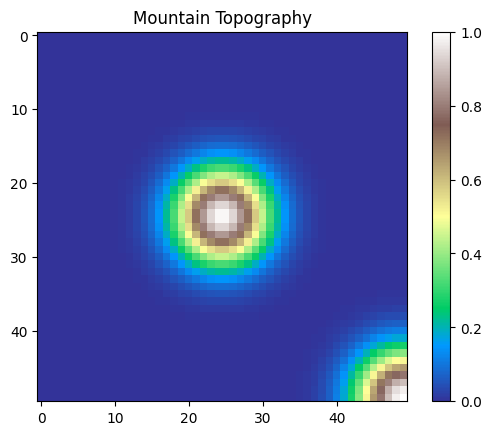

In [5]:
def mountain_dem(width = 50, height = 50):
    """
    Generates a digital elevation model (DEM) of a mountain with a Gaussian shape.

    Parameters
    ----------
    width : int, optional
        The width of the DEM grid, in number of cells. Default is 50.
    height : int, optional
        The height of the DEM grid, in number of cells. Default is 50.

    Returns
    -------
    dem : numpy.ndarray
        A 2D numpy array containing the elevation levels of the mountain.
    """
    # define the x and y values and create grid
    x = np.linspace(-1, 1, width)
    y = np.linspace(-1, 1, height)
    X, Y = np.meshgrid(x, y)

    # define height function for the mountain
    dem_func = lambda x, y: np.exp(-((4 * x)**2 + (4 * y)**2)) + np.exp(-((4 * (x - 1))**2 + (4 * (y - 1))**2))

    # generate 2D array of elevation levels
    dem = dem_func(X, Y)
    return dem

mountain_dem = mountain_dem()
plt.imshow(mountain_dem, cmap = 'terrain')
plt.title('Mountain Topography')
plt.colorbar()
plt.show()

In [6]:
test(mountain_dem, rain_region = [[20, 30], [20, 30]])

<Figure size 1000x800 with 0 Axes>

In [7]:
test(mountain_dem, rain_region = [[20, 30], [20, 30]], layer = 'Infiltration Level')

<Figure size 1000x800 with 0 Axes>

In [8]:
test(mountain_dem, rain_region = [[20, 30], [20, 30]], layer = 'Flooded Cells')

<Figure size 1000x800 with 0 Axes>

### Flat 

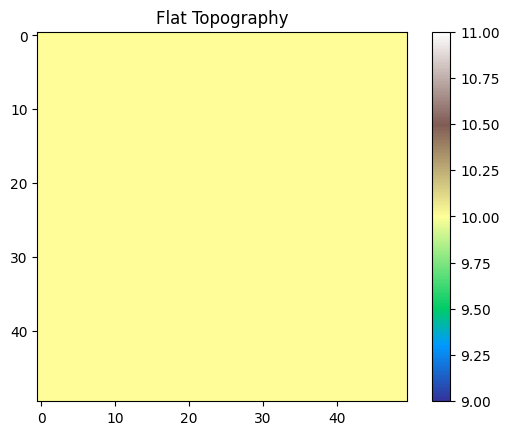

In [9]:
def flat_dem(elevation = 10, width = 50, height = 50):
    """
    Generates a digital elevation model (DEM) of a flat surface with a constant elevation.

    Parameters
    ----------
    elevation : int, optional
        The elevation of the flat surface, in meters. Default is 10.
    width : int, optional
        The width of the DEM grid, in number of cells. Default is 50.
    height : int, optional
        The height of the DEM grid, in number of cells. Default is 50.

    Returns
    -------
    dem : numpy.ndarray
        A 2D numpy array containing the elevation levels of the flat surface.
    """
    dem = np.array([[elevation]*width]*height)
    return dem

flat_dem = flat_dem()
plt.imshow(flat_dem, cmap = 'terrain')
plt.title('Flat Topography')
plt.colorbar()
plt.show()

In [10]:
test(flat_dem, rain_region = [[20, 30], [20, 30]])

<Figure size 1000x800 with 0 Axes>

In [11]:
test(flat_dem, rain_region = [[20, 30], [20, 30]], layer = 'Infiltration Level')

<Figure size 1000x800 with 0 Axes>

In [12]:
test(flat_dem, rain_region = [[20, 30], [20, 30]], layer = 'Flooded Cells')

<Figure size 1000x800 with 0 Axes>

### Fractal

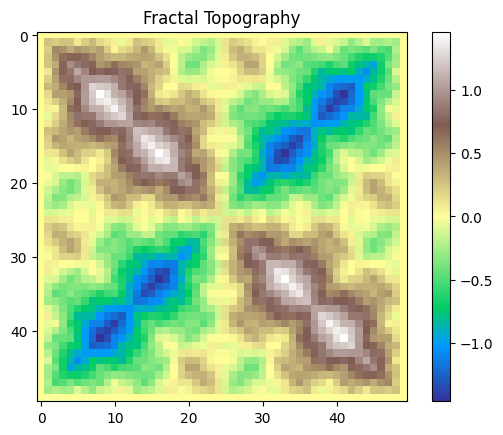

In [13]:
def fractal_dem(width = 50, height = 50, octaves=6, persistence=0.5, lacunarity=2.0):
    # define x and y values and create grid
    x = np.linspace(-1, 1, width)
    y = np.linspace(-1, 1, height)
    X, Y = np.meshgrid(x, y)

    # define height function using fractal noise
    def height_func(x, y):
        noise_val = 0
        freq = 1
        amp = 1
        # generate noise for each value
        for i in range(octaves):
            noise_val += amp * np.sin(freq * np.pi * x) * np.sin(freq * np.pi * y)
            freq *= lacunarity
            amp *= persistence
        return noise_val

    # create elevation for each cell
    dem = np.zeros((height, width))
    for i in range(height):
        for j in range(width):
            dem[i, j] = height_func(x[j], y[i])

    return dem

fractal_dem = fractal_dem()
plt.imshow(fractal_dem, cmap = 'terrain')
plt.title('Fractal Topography')
plt.colorbar()
plt.show()

In [14]:
test(flat_dem, rain_region = [[20, 30], [20, 30]],rain_dist = sts.uniform(5, 10), infiltration_rate = 0.5)

<Figure size 1000x800 with 0 Axes>

In [15]:
test(flat_dem, rain_region = [[20, 30], [20, 30]], layer = 'Infiltration Level')

<Figure size 1000x800 with 0 Axes>

In [16]:
test(flat_dem, rain_region = [[20, 30], [20, 30]], layer = 'Flooded Cells')

<Figure size 1000x800 with 0 Axes>

### Lake

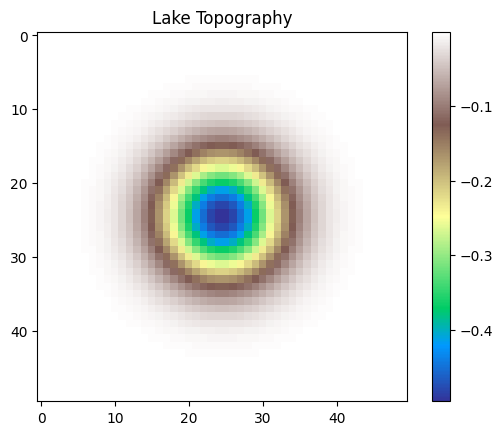

In [17]:
def lake_dem(width = 50, height = 50):
    """
    Generates a digital elevation model (DEM) of a lake with a Gaussian shape.

    Parameters
    ----------
    width : int, optional
        The width of the DEM grid, in number of cells. Default is 50.
    height : int, optional
        The height of the DEM grid, in number of cells. Default is 50.

    Returns
    -------
    dem : numpy.ndarray
        A 2D numpy array containing the elevation levels of the lake.
    """
    # define x and y values and create grid
    x = np.linspace(-0.5, 0.5, width)
    y = np.linspace(-0.5, 0.5, height)
    X, Y = np.meshgrid(x, y)

    # define height function for lake
    height_func = lambda x, y: -0.5 * np.exp(-((6 * x)**2 + (6 * y)**2))

    # generate elevation values
    dem = height_func(X, Y)
    return dem

lake_dem = lake_dem()
plt.imshow(lake_dem, cmap = 'terrain')
plt.title('Lake Topography')
plt.colorbar()
plt.show()

In [18]:
test(lake_dem, rain_region = [[20, 30], [20, 30]])

<Figure size 1000x800 with 0 Axes>

In [19]:
test(lake_dem, rain_region = [[20, 30], [20, 30]], layer = 'Infiltration Level')

<Figure size 1000x800 with 0 Axes>

In [20]:
test(lake_dem, rain_region = [[20, 30], [20, 30]], layer = 'Flooded Cells')

<Figure size 1000x800 with 0 Axes>

## Loading DEM Data

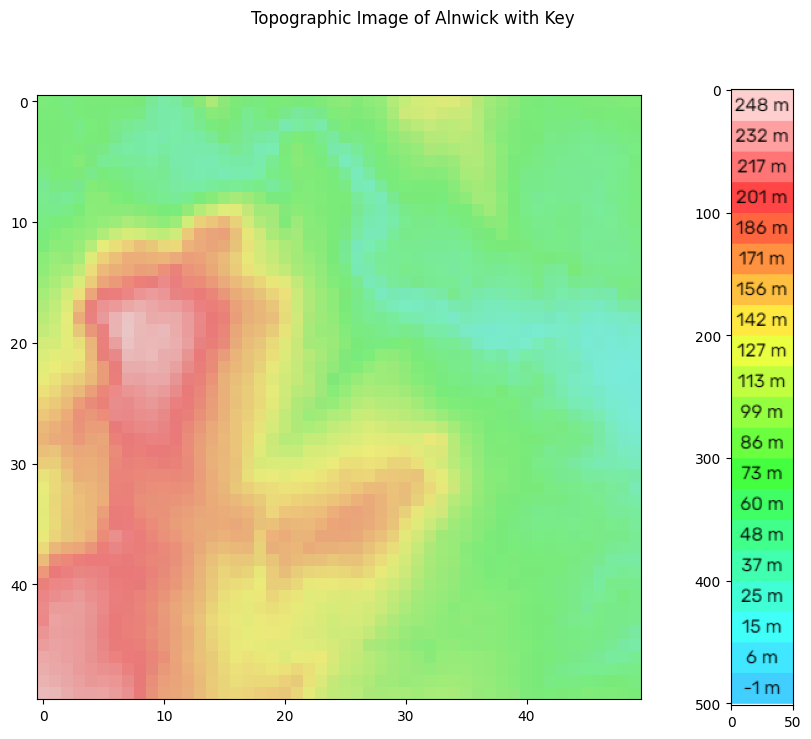

In [21]:
# upload the topographic map and key images
fig, ax = plt.subplots(1, 2, figsize = (10, 8), gridspec_kw={'width_ratios': [6, 1]})
key_image = cv2.imread('/content/drive/MyDrive/CS166_Final/Alnwick_topography_key.png')
key_image_rgb = cv2.cvtColor(key_image, cv2.COLOR_BGR2RGB)
ax[1].imshow(key_image_rgb)

map_image = cv2.imread('/content/drive/MyDrive/CS166_Final/Alnwick_topography_no_roads.png')
map_image_rgb = cv2.cvtColor(map_image, cv2.COLOR_BGR2RGB)
map_image_rgb_resized = cv2.resize(map_image_rgb, (50, 50))
ax[0].imshow(map_image_rgb_resized)
fig.suptitle('Topographic Image of Alnwick with Key')
plt.show()

In [22]:
def extract_colourmap(key_image, key_image_rgb):
    """
    Extract a colour elevation map from an image.

    Parameters
    ----------
    key_image : numpy.ndarray
        An image containing elevation information.

    Returns
    -------
    colour_elevation_map : dict
        A dictionary mapping RGB color tuples to elevation values.

    """
    # define regions of the image to sample from
    y1, y2, y3, y4 = 10, 11, 0, 25
    x1, x2, x3, x4 = 0, 1, 0, 50
    step_y = 25

    # loop over 20 regions of the image and extract color and elevation values
    colour_elevation_pairs = []
    for i in range(20):

        # extract the RGB color of the region
        colour_block = key_image_rgb[y1:y2, x1:x2]
        colour = tuple(np.mean(colour_block.reshape(-1, 3), axis=0).astype(int))
        
        # extract the elevation value of the region
        elevation_region = key_image[y3:y4, x3:x4]
        elevation = int(pytesseract.image_to_string(elevation_region, config='--psm 6 -c tessedit_char_whitelist=0123456789'))
        colour_elevation_pairs.append((colour, elevation))

        y1 += step_y
        y2 += step_y
        y3 += step_y
        y4 += step_y

    colour_elevation_map = {colour: elevation for colour, elevation in colour_elevation_pairs}

    # correct mistake in pytesseract reading
    colour_elevation_map[(191, 255, 64)] = 113
    return colour_elevation_map

colour_elevation_map = extract_colourmap(key_image, key_image_rgb)
print(colour_elevation_map)

{(255, 206, 206): 248, (255, 160, 160): 232, (255, 116, 116): 217, (255, 69, 69): 201, (255, 102, 64): 186, (255, 146, 64): 171, (255, 191, 64): 156, (255, 233, 64): 142, (233, 255, 64): 127, (191, 255, 64): 113, (148, 255, 64): 99, (107, 255, 64): 86, (68, 255, 64): 73, (64, 255, 101): 60, (64, 255, 139): 48, (64, 255, 174): 37, (64, 255, 214): 25, (64, 255, 248): 15, (64, 231, 255): 6, (64, 207, 255): 1}


In [24]:
def get_elevation_grid(map_image_rgb_resized, colour_elevation_map):
    """
    Given an RGB image map_image_rgb_resized and a colour-elevation map colour_elevation_map, 
    return an elevation grid for the image.
    
    Parameters
    ----------
    map_image_rgb_resized : numpy.ndarray
        An RGB image to extract the elevation information from.
    colour_elevation_map : dict
        A dictionary mapping RGB colour tuples to elevation values.
    
    Returns
    -------
    numpy.ndarray
        An array of the same shape as map_image_rgb_resized, where each element is an elevation value.
    
    """
    elevation_grid = np.zeros((map_image_rgb_resized.shape[0], map_image_rgb_resized.shape[1]))

    # define colour difference function
    def colour_difference(colour1, colour2):
        """
        Compute the CIE2000 colour difference between two RGB colours.
        
        Parameters
        ----------
        colour1 : tuple of ints
            An RGB colour as a tuple of integers in the range 0-255.
        colour2 : tuple of ints
            An RGB colour as a tuple of integers in the range 0-255.
        
        Returns
        -------
        float
            The CIE2000 colour difference between the two colours.
        
        """
        lab1 = convert_color(sRGBColor(*colour1), LabColor)
        lab2 = convert_color(sRGBColor(*colour2), LabColor)
        return delta_e_cie2000(lab1, lab2)

    # loop over all pixels in the image and compute the elevation value for each pixel
    for i in range(map_image_rgb_resized.shape[0]):
        for j in range(map_image_rgb_resized.shape[1]):

            # get RGB color of the current pixel
            colour = tuple(map_image_rgb_resized[i, j])
            
            # compute colour differences between the current colour and each colour in the elevation map
            colour_differences = [(key, colour_difference(colour, key)) for key in colour_elevation_map.keys()]
            
            # sort the colour differences in ascending order and get the two colours with the smallest differences
            sorted_colour_differences = sorted(colour_differences, key=lambda x: x[1])
            colour1, distance1 = sorted_colour_differences[0]
            colour2, distance2 = sorted_colour_differences[1]
            
            # compute the weights for the two colours based on their distances
            weight1 = distance2 / (distance1 + distance2)
            weight2 = distance1 / (distance1 + distance2)
            
            # compute the elevation value for the current pixel (weighted average)
            elevation = weight1 * colour_elevation_map[colour1] + weight2 * colour_elevation_map[colour2]
            elevation_grid[i, j] = elevation

    return elevation_grid

elevation_grid = get_elevation_grid(map_image_rgb_resized, colour_elevation_map)

## Testing the Simulation: DEM Data

### Rain at Start

In [25]:
test(elevation_grid, infiltration_rate = 0.5, groundwater_rate = 0.2, infiltration_max = 5, 
         min_flooded = 1, layer = 'Water Level', rain_dist = sts.uniform(5, 8))

<Figure size 1000x800 with 0 Axes>

In [26]:
test(elevation_grid, infiltration_rate = 0.5, groundwater_rate = 0.2, infiltration_max = 5, 
         min_flooded = 1, layer = 'Flooded Cells', rain_dist = sts.uniform(5, 8))

<Figure size 1000x800 with 0 Axes>

In [27]:
test(elevation_grid, infiltration_rate = 0.5, groundwater_rate = 0.2, infiltration_max = 5, 
         min_flooded = 1, layer = 'Infiltration Level', rain_dist = sts.uniform(5, 8))

<Figure size 1000x800 with 0 Axes>

In [28]:
test(elevation_grid, groundwater_rate = 0, infiltration_max = 0, infiltration_rate = 0.5, 
         min_flooded = 1, layer = 'Water Level', rain_dist = sts.uniform(5, 8))

<Figure size 1000x800 with 0 Axes>

In [29]:
test(elevation_grid, groundwater_rate = 0, infiltration_max = 0, infiltration_rate = 0.5, 
         min_flooded = 1, layer = 'Flooded Cells', rain_dist = sts.uniform(5, 8))

<Figure size 1000x800 with 0 Axes>

In [30]:
test(elevation_grid, groundwater_rate = 0, infiltration_max = 0, infiltration_rate = 0.5, 
         min_flooded = 1, layer = 'Infiltration Level', rain_dist = sts.uniform(5, 8))

<Figure size 1000x800 with 0 Axes>

### Rain Throughout

In [31]:
# code is adapted from CS166, session 6
def test_rain_throughout(elevation_map, infiltration_rate = 0.5, groundwater_rate = 0.2, infiltration_max = 5, 
         region_x = [0, 49], region_y = [0, 49], rain_dist = sts.uniform(1, 3), layer = 'Water Level'):
    """
    Test the `FloodingSimulation` object by animating the effect of rain on the elevation map.

    Parameters
    ----------
    elevation_map : numpy.ndarray
        The elevation map of the region to be simulated.
    infiltration_rate : float, optional
        The rate at which the soil absorbs water. Default is 0.5.
    groundwater_rate : float, optional
        The rate at which water seeps from the soil to the groundwater. Default is 0.2.
    infiltration_max : float, optional
        The maximum amount of water the soil can absorb per unit area. Default is 5.
    region_x : 2-element list of integers, optional
        The range of columns for rain to be simulated, as [xmin, xmax]. Default is [0, 49].
    region_y : 2-element list of integers, optional
        The range of rows for rain to be simulated, as [ymin, ymax]. Default is [0, 49].
    rain_dist : scipy.stats distribution, optional
        The distribution of the amount of rain falling on each cell. Default is uniform(1, 3).
    layer : str, optional
        The name of the layer to be plotted. Default is 'Water Level'.

    Returns
    -------
    output : IPython.display.HTML
        The HTML representation of the animation.
    """
    sim = FloodingSimulation(dem = elevation_map, infiltration_rate = infiltration_rate, 
                             groundwater_rate = groundwater_rate, infiltration_max = infiltration_max)
    
    # generate animation, specifying layer to display
    animation = FuncAnimation(sim.figure, sim.animate_rain, frames=20, interval=400, fargs = (region_x, region_y, rain_dist, layer)) 
    output = HTML(animation.to_html5_video())
    sim.figure.clf()
    display(output)

In [32]:
test_rain_throughout(elevation_grid)

<Figure size 1000x800 with 0 Axes>

In [33]:
test_rain_throughout(elevation_grid, layer = 'Flooded Cells')

<Figure size 1000x800 with 0 Axes>

In [34]:
test_rain_throughout(elevation_grid, layer = 'Infiltration Level')

<Figure size 1000x800 with 0 Axes>

In [35]:
test_rain_throughout(elevation_grid, groundwater_rate = 0, infiltration_max = 0)

<Figure size 1000x800 with 0 Axes>

In [36]:
test_rain_throughout(elevation_grid, groundwater_rate = 0, infiltration_max = 0, layer = 'Flooded Cells')

<Figure size 1000x800 with 0 Axes>

In [37]:
test_rain_throughout(elevation_grid, groundwater_rate = 0, infiltration_max = 0, layer = 'Infiltration Level')

<Figure size 1000x800 with 0 Axes>

In [38]:
test_rain_throughout(elevation_grid, infiltration_rate = 1, groundwater_rate = 1, rain_dist = sts.uniform(1, 1))

<Figure size 1000x800 with 0 Axes>

In [39]:
test_rain_throughout(elevation_grid, infiltration_rate = 1, groundwater_rate = 1, rain_dist = sts.uniform(1, 1), layer = 'Flooded Cells')

<Figure size 1000x800 with 0 Axes>

## Flooding Stable States

### Empirical Analysis

In [40]:
def plot_flooding(elevation_map, trials = 20, steps = 50, infiltration_rate = 0, 
                  groundwater_rate = 0, infiltration_max = 0, min_flooded = 0):
    """
    Plots the stable flooded proportion for different initial flooding levels.

    Parameters
    ----------
    elevation_map : numpy.ndarray
        An array representing the elevation map of the terrain.
    trials : int, optional
        The number of simulations to run for each initial flooding level. Default is 20.
    steps : int, optional
        The number of simulation steps to run for each trial. Default is 50.
    infiltration_rate : float, optional
        The infiltration rate of the terrain. Default is 0.
    groundwater_rate : float, optional
        The groundwater rate of the terrain. Default is 0.
    infiltration_max : float, optional
        The maximum infiltration rate of the terrain. Default is 0.
    min_flooded : float, optional
        The minimum flooded proportion for the terrain. Default is 0.

    Returns
    -------
    None
    """
    # initial flooding levels (given as amount of rain)
    rain_proportion = np.arange(0, 1.01, 0.05)
    flooding = []
    flooding_se = []
    flooding_upper = []
    flooding_lower = []

    for p in rain_proportion:
        
        flooding_per_p = []
        for _ in range(trials):

            sim = FloodingSimulation(dem = elevation_map, infiltration_rate = infiltration_rate, 
                             groundwater_rate = groundwater_rate, infiltration_max = infiltration_max, 
                             min_flooded = min_flooded, surpress_axis = True)
            
            # only rain at the beginning
            sim.random_rain(p, sts.uniform(1, 1))
            for _ in range(steps):
                sim.update()
            
            # final state over time is the closest to the stable state
            flooding_per_p.append(sim.flooded_over_time[-1])

        flooding.append(np.mean(flooding_per_p))
        flooding_se.append(sts.sem(flooding_per_p))
        flooding_upper.append(np.quantile(flooding_per_p, 0.975))
        flooding_lower.append(np.quantile(flooding_per_p, 0.025))

    # plot intervals, mean & theoretical approximation
    plt.plot(rain_proportion, flooding, color = 'cornflowerblue', label = 'Mean')
    plt.plot(rain_proportion, np.array(flooding)-1.96*np.array(flooding_se), color = 'cornflowerblue', linestyle = 'dashed', label = '95% mean CI')
    plt.plot(rain_proportion, np.array(flooding)+1.96*np.array(flooding_se), color = 'cornflowerblue', linestyle = 'dashed')
    plt.axhline(0.47, color = 'orange', label = 'Theoretical stable state')
    plt.fill_between(rain_proportion, flooding_lower, flooding_upper, alpha = 0.3, color = 'cornflowerblue', label = '95% data CI')
    plt.title('Flooding Stable States with Different Initial Flooding Levels')
    plt.xlabel('Initial flooded proportion')
    plt.ylabel('Stable flooded proportion')
    plt.legend()
    plt.show()

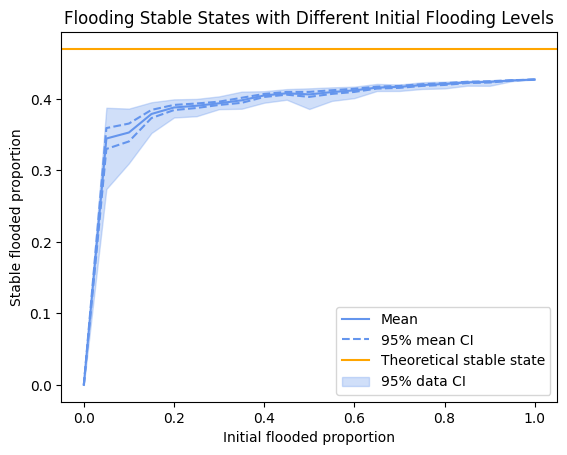

In [41]:
plot_flooding(elevation_grid)

### Theoretical Analysis: Cobweb Plot

In [42]:
def make_higher_comparisons(elevation_grid):
    """
    Computes the proportion of cells in an elevation grid that have higher elevation than at 
    least one of their neighbouring cells.

    Parameters
    ----------
    elevation_grid : numpy.ndarray
        A 2D numpy array representing the elevation grid. The shape of the array should be (n, m), 
        where n is the number of rows and m is the number of columns.

    Returns
    -------
    None
    """
    comparisons = 0
    greater = 0

    for i in range(1, len(elevation_grid)-1):
        for j in range(1, len(elevation_grid[0])-1):
            elevation = elevation_grid[i, j]

            # check all neighbour elevations
            for ni, nj in [(i-1, j), (i, j+1), (i+1, j), (i, j-1),
                    (i-1, j-1), (i-1, j+1), (i+1, j-1), (i+1, j+1)]:
                comparisons += 1

                # compare elevations
                if elevation_grid[ni, nj] > elevation:
                    greater += 1

    print('Proportion of cells with greater elevation:', round(greater/comparisons))

make_higher_comparisons(elevation_grid)

Proportion of cells with greater elevation: 0


Stable State of 0.0


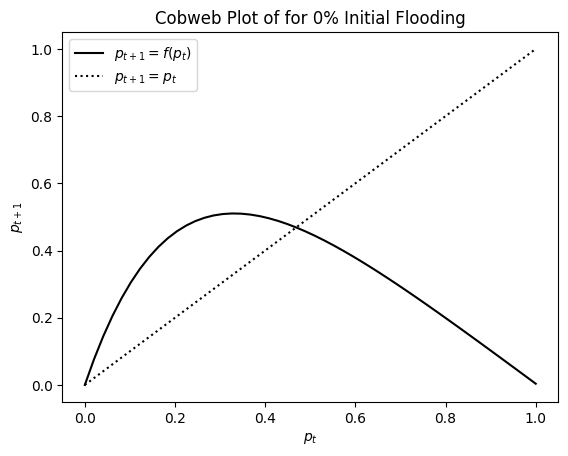

Stable State of 0.469


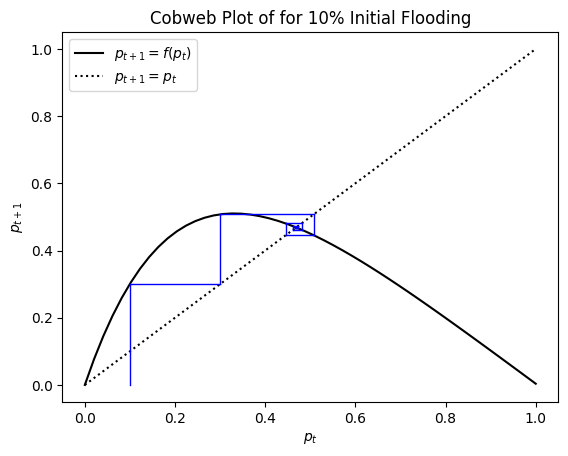

Stable State of 0.469


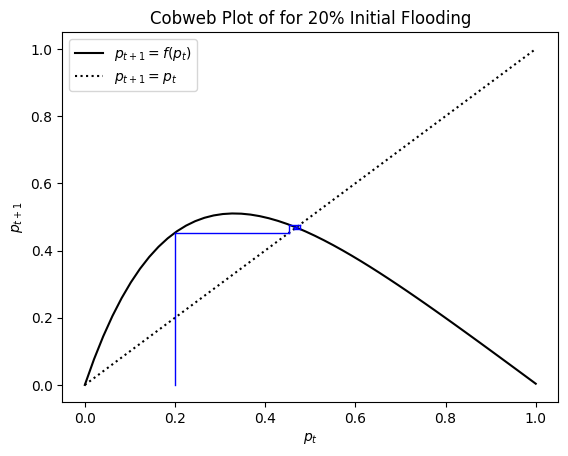

Stable State of 0.469


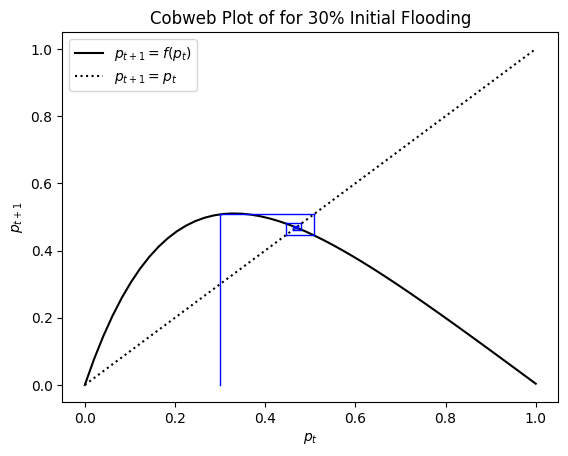

Stable State of 0.469


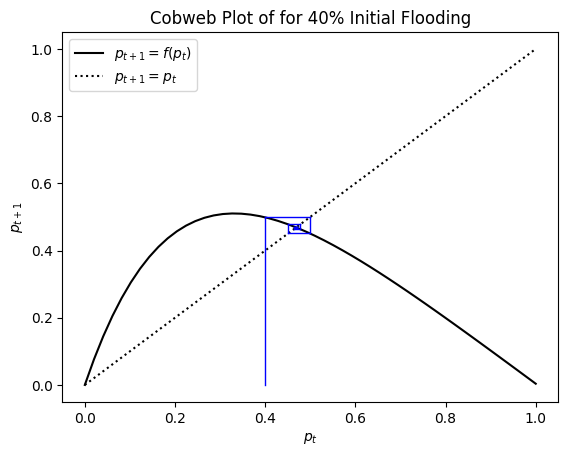

Stable State of 0.469


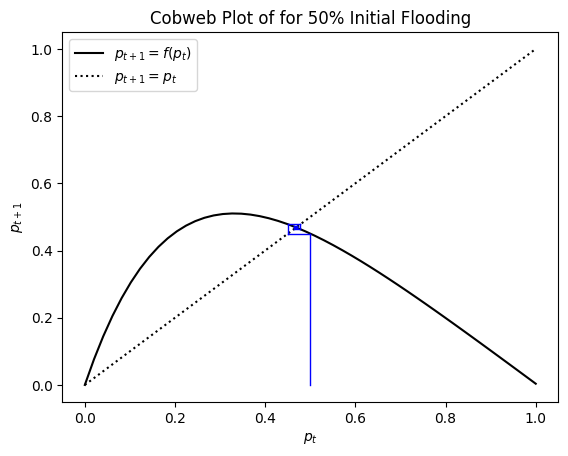

Stable State of 0.469


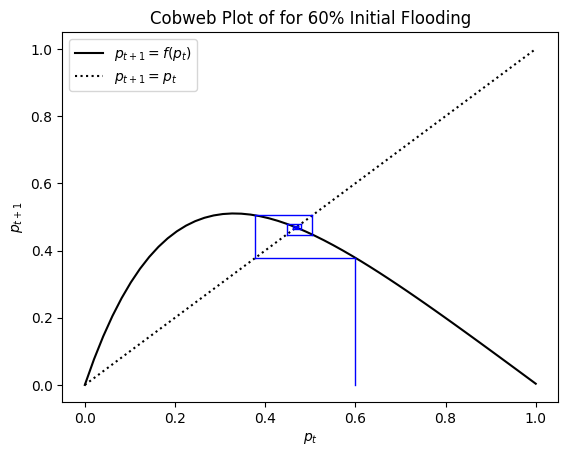

Stable State of 0.469


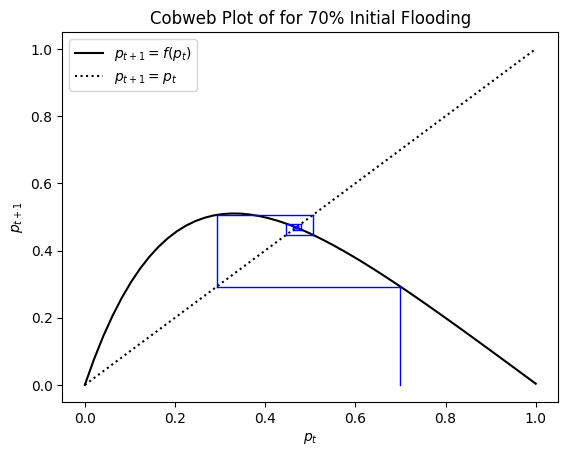

Stable State of 0.469


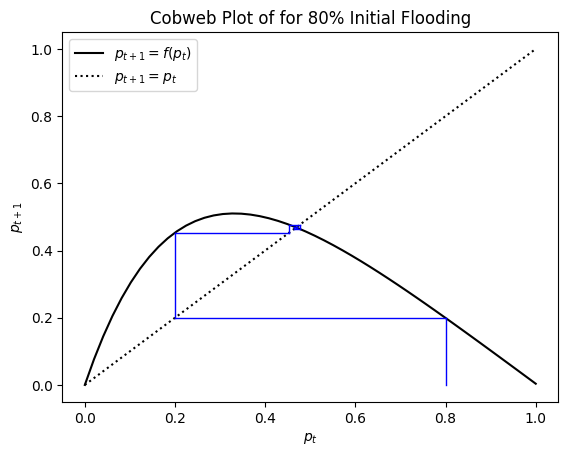

Stable State of 0.469


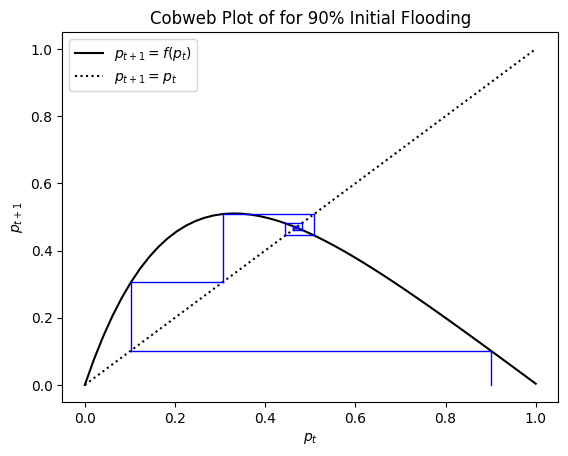

Stable State of 0.469


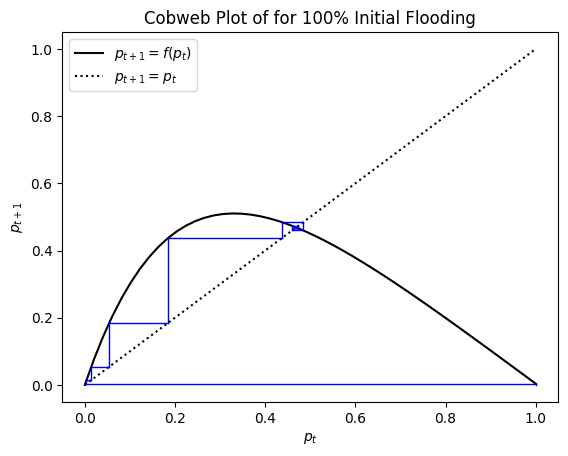

In [43]:
def cobweb(f, x0, N, a=0, b=1):
    """
    Generates a cobweb plot of a function and its fixed points.

    Parameters
    ----------
    f : callable
        The function to generate the cobweb plot for.
    x0 : float
        The initial value to use in the plot.
    N : int
        The number of iterations to run the cobweb plot for.
    a, b : float, optional
        The domain to plot the function over, by default (0, 1).

    Returns
    -------
    None
    """

    # plots the initial x=y line and function line
    t = np.linspace(a, b, N)
    plt.plot(t, f(t), 'k', label = '$p_{t+1} = f(p_t)$')
    plt.plot(t, t, "k:", label = '$p_{t+1} = p_t$')

    x, y = x0, f(x0)
    plt.plot([x0, x0], [0, f(x0)], 'b', linewidth=1)

    # plots the cobweb path, updating the initial and next values
    for _ in range(N):
        fy = f(y)        
        plt.plot([x, y], [y,  y], 'b', linewidth=1)
        plt.plot([y, y], [y, fy], 'b', linewidth=1)
        x, y = y, fy

    print(f'Stable State of {round(y, 3)}')
    plt.xlabel('$p_t$')
    plt.ylabel('$p_{t+1}$')
    plt.title(f'Cobweb Plot of for {round(x0*100)}% Initial Flooding')
    plt.legend()
    plt.show()

def func(p):
    """
    Defines the difference equation used to plot a cobweb plot.

    Parameters
    ----------
    p : float
        Parameter of the equation.

    Returns
    -------
    None
    """
    p_e = 0.495
    return (1-p)*(1-(1-p_e*p)**8) + p * p_e**8

for i in np.arange(0, 1.01, 0.1):
    cobweb(func, i, 50)

## Flooding Prevention Mechanisms

### Drainage Basins

In [44]:
def plot_drainage_flooding_over_time(elevation_map, trials = 20, steps = 20, infiltration_rate = 0.2, 
                  groundwater_rate = 0.2, infiltration_max = 5, min_flooded = 0, prop_drainage = []):
    """
    Plot the flooded proportion over time for different coverage percentages of drainage basins.

    Parameters
    ----------
    elevation_map : numpy.ndarray
        Array of elevation values.
    trials : int, optional
        Number of trials to run for each coverage percentage of drainage basins. Default is 20.
    steps : int, optional
        Number of simulation steps to run for each trial. Default is 20.
    infiltration_rate : float, optional
        Rate at which water infiltrates into the soil. Default is 0.2.
    groundwater_rate : float, optional
        Rate at which water flows through the soil. Default is 0.2.
    infiltration_max : float, optional
        Maximum amount of water that can infiltrate into the soil per unit time. Default is 5.
    min_flooded : float, optional
        Minimum amount of flooding required to count a cell as flooded. Default is 0.
    prop_drainage : list of float, optional
        List of coverage percentages of drainage basins to simulate. Default is an empty list.

    Returns
    -------
    None
    """
    fig, ax = plt.subplots(1, 4, figsize = (15, 5), sharex = True, sharey = True)

    # plot each drainage coverage on a subplot
    for i, p in enumerate(prop_drainage):

        flooding = []
        for _ in range(trials):

            sim = FloodingSimulation(dem = elevation_map, infiltration_rate = infiltration_rate, 
                                groundwater_rate = groundwater_rate, infiltration_max = infiltration_max, 
                                min_flooded = min_flooded, surpress_axis = True)
            
            # add drainage basins and simulate rainfall
            sim.add_drainage_basins(p)
            sim.random_rain(1, sts.uniform(1, 1))

            for _ in range(steps):
                sim.update()      

            # correct for flooded drainage basins
            flooding.append(np.array(sim.flooded_over_time) - p)

        # plot confidence intervals (data, mean) and mean
        ax[i].plot(range(steps+1), np.mean(flooding, axis = 0), color = 'cornflowerblue', label = 'Mean')
        ax[i].plot(range(steps+1), np.array(np.mean(flooding, axis = 0))-1.96*np.array(sts.sem(flooding, axis = 0)), 
                color = 'cornflowerblue', linestyle = 'dashed', label = '95% mean CI')
        ax[i].plot(range(steps+1), np.array(np.mean(flooding, axis = 0))+1.96*np.array(sts.sem(flooding, axis = 0)), 
                color = 'cornflowerblue', linestyle = 'dashed')
        ax[i].fill_between(range(steps+1), np.quantile(flooding, 0.025, axis = 0), 
                        np.quantile(flooding, 0.975, axis = 0), alpha = 0.3, color = 'cornflowerblue', label = '95% data CI')
        ax[i].set_title(f'{round(p*100)}% Coverage')

    plt.ylim(0, 1)
    fig.suptitle('Flooding Over Time')
    fig.supxlabel('Timestep')
    fig.supylabel('Flooded proportion')
    fig.tight_layout()
    ax[3].legend()
    plt.show()

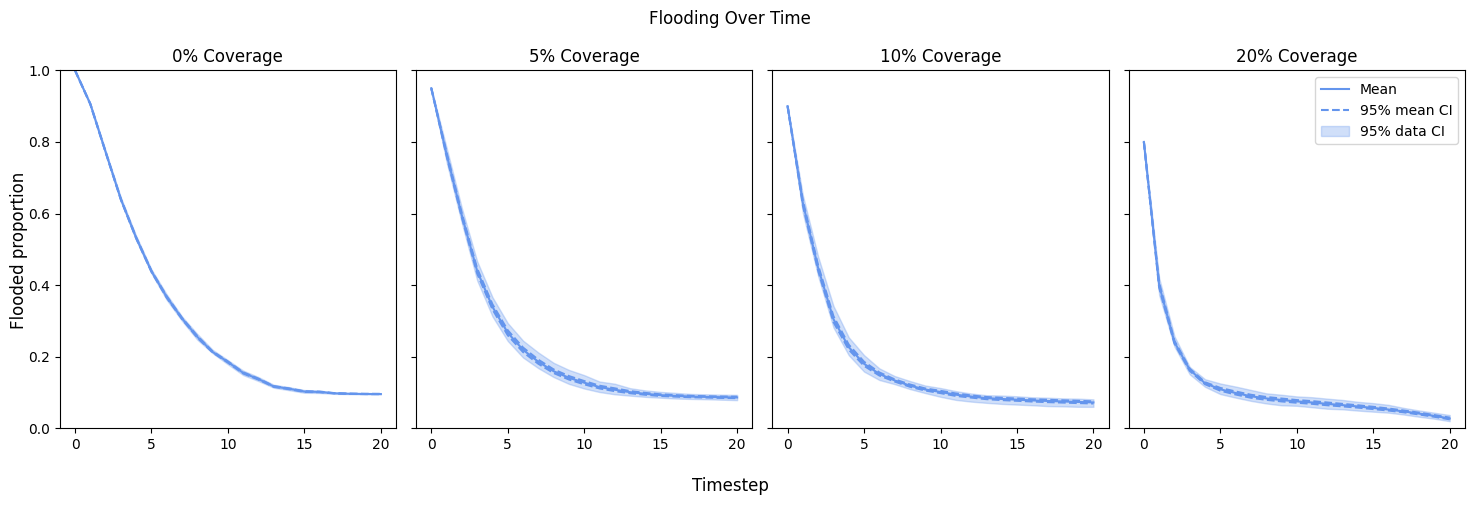

In [45]:
plot_drainage_flooding_over_time(elevation_grid, prop_drainage = [0, 0.05, 0.1, 0.2])

In [46]:
def plot_drainage_flooding_hist(elevation_map, trials = 20, steps = 20, infiltration_rate = 0.2, 
                  groundwater_rate = 0.2, infiltration_max = 5, min_flooded = 0, prop_drainage = []):
    """
    Plot the flooded proportion distribution as a histogram for different coverage percentages 
    of drainage basins.

    Parameters
    ----------
    elevation_map : numpy.ndarray
        Array of elevation values.
    trials : int, optional
        Number of trials to run for each coverage percentage of drainage basins. Default is 20.
    steps : int, optional
        Number of simulation steps to run for each trial. Default is 20.
    infiltration_rate : float, optional
        Rate at which water infiltrates into the soil. Default is 0.2.
    groundwater_rate : float, optional
        Rate at which water flows through the soil. Default is 0.2.
    infiltration_max : float, optional
        Maximum amount of water that can infiltrate into the soil per unit time. Default is 5.
    min_flooded : float, optional
        Minimum amount of flooding required to count a cell as flooded. Default is 0.
    prop_drainage : list of float, optional
        List of coverage percentages of drainage basins to simulate. Default is an empty list.

    Returns
    -------
    None
    """
    fig, ax = plt.subplots(1, 4, figsize = (15, 5), sharex = True, sharey = True)

    # plot each drainage coverage on a subplot
    for i, p in enumerate(prop_drainage):

        flooding = []
        for _ in range(trials):

            sim = FloodingSimulation(dem = elevation_map, infiltration_rate = infiltration_rate, 
                                groundwater_rate = groundwater_rate, infiltration_max = infiltration_max, 
                                min_flooded = min_flooded, surpress_axis = True)
            
            # add drainage basins and simulate rainfall
            sim.add_drainage_basins(p)
            sim.random_rain(1, sts.uniform(1, 1))
            
            for _ in range(steps):
                sim.update()      

            # correct for flooded drainage basins
            flooding.append(np.array(sim.flooded_over_time) - p)

        # plot confidence intervals (data, mean) and mean
        ax[i].hist(np.array(flooding).flatten(), alpha = 0.9, label = 'Distribution', color = 'cornflowerblue')
        ax[i].axvline(np.quantile(flooding, 0.025), label = '95% data CI', color = 'orange')
        ax[i].axvline(np.quantile(flooding, 0.975), color = 'orange')
        ax[i].axvline((np.mean(flooding)-1.96*sts.sem(flooding))[0], label = '95% mean CI', color = 'black', linestyle = 'dashed')
        ax[i].axvline((np.mean(flooding)+1.96*sts.sem(flooding))[0])
        ax[i].axvline(np.mean(flooding), label = 'Mean', color = 'black')
        ax[i].set_title(f'{round(p*100)}% Coverage')

    fig.suptitle('Flooding Distributions')
    fig.supxlabel('Flooding proportion')
    fig.supylabel('Frequency')
    fig.tight_layout()
    ax[3].legend()
    plt.show()

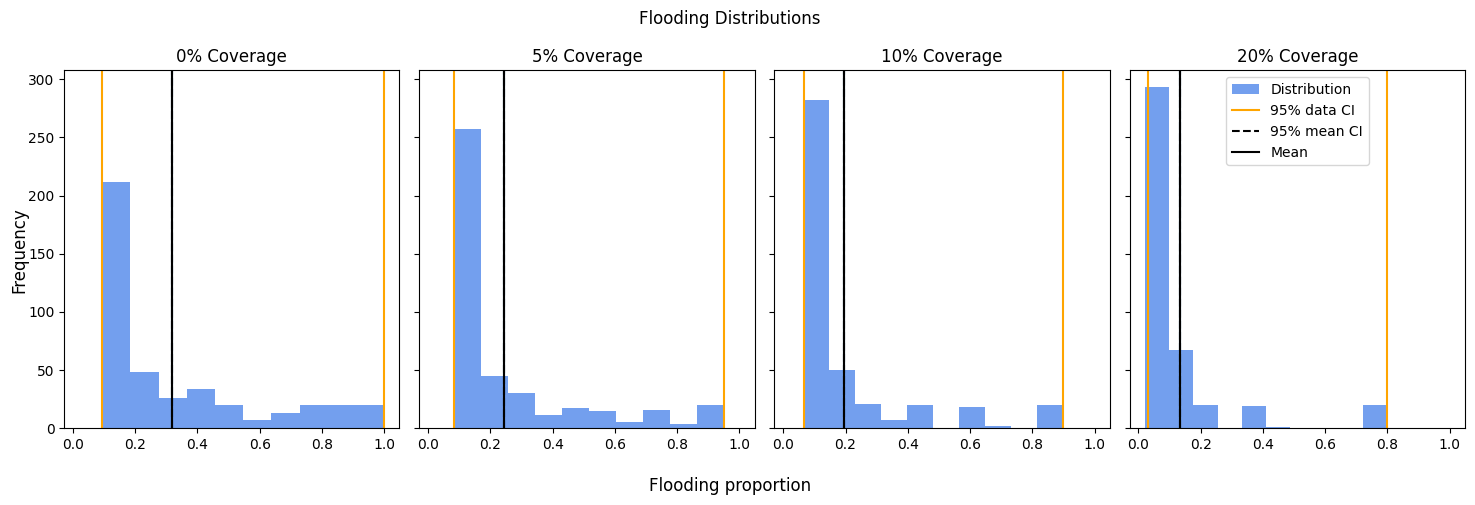

In [47]:
plot_drainage_flooding_hist(elevation_grid, prop_drainage = [0, 0.05, 0.1, 0.2])

### Building a Wall

In [48]:
def plot_wall_flooding_over_time(elevation_map, wall_positions, trials = 10, steps = 20, infiltration_rate = 0.2, 
                  groundwater_rate = 0.2, infiltration_max = 5, min_flooded = 0):
    """
    Plot the flooded proportion over time for different wall positions.

    Parameters
    ----------
    elevation_map : numpy.ndarray
        Array of elevation values.
    wall_positions : list of tuples
        List of wall positions. Each tuple should contain the row and column ranges of the wall location.
    trials : int, optional
        Number of trials to run for each wall position. Default is 10.
    steps : int, optional
        Number of simulation steps to run for each trial. Default is 20.
    infiltration_rate : float, optional
        Rate at which water infiltrates into the soil. Default is 0.2.
    groundwater_rate : float, optional
        Rate at which water flows through the soil. Default is 0.2.
    infiltration_max : float, optional
        Maximum amount of water that can infiltrate into the soil per unit time. Default is 5.
    min_flooded : float, optional
        Minimum amount of flooding required to count a cell as flooded. Default is 0.

    Returns
    -------
    None
    """
    fig, ax = plt.subplots(1, 3, figsize = (12, 5), sharex = True, sharey = True)

    # plot each wall on different subplot
    for i, p in enumerate(wall_positions):

        flooding = []
        for _ in range(trials):

            sim = FloodingSimulation(dem = elevation_map, infiltration_rate = infiltration_rate, 
                                groundwater_rate = groundwater_rate, infiltration_max = infiltration_max, 
                                min_flooded = min_flooded, surpress_axis = True)
            
            # add wall to grid and simulate rainfall
            sim.add_wall(p[0], p[1])
            sim.random_rain(1, sts.uniform(1, 1))

            for _ in range(steps):
                sim.update()      

            # correct for walls
            flooding.append(np.array(sim.flooded_over_time) - 1/50)

        # plot confidence intervals (data, mean) and mean
        ax[i].plot(range(steps+1), np.mean(flooding, axis = 0), color = 'cornflowerblue', label = 'Mean')
        ax[i].plot(range(steps+1), np.array(np.mean(flooding, axis = 0))-1.96*np.array(sts.sem(flooding, axis = 0)), 
                color = 'cornflowerblue', linestyle = 'dashed', label = '95% mean CI')
        ax[i].plot(range(steps+1), np.array(np.mean(flooding, axis = 0))+1.96*np.array(sts.sem(flooding, axis = 0)), 
                color = 'cornflowerblue', linestyle = 'dashed')
        ax[i].fill_between(range(steps+1), np.quantile(flooding, 0.025, axis = 0), 
                        np.quantile(flooding, 0.975, axis = 0), alpha = 0.3, color = 'cornflowerblue', label = '95% data CI')
        if len(p[1]) == 0:
            ax[i].set_title(f'No Wall')
        else:
            ax[i].set_title(f'Wall at Position {p[1][0]}')

    plt.ylim(0, 1)
    fig.suptitle('Flooding Over Time')
    fig.supxlabel('Timestep')
    fig.supylabel('Flooded proportion')
    fig.tight_layout()
    ax[2].legend()
    plt.show()

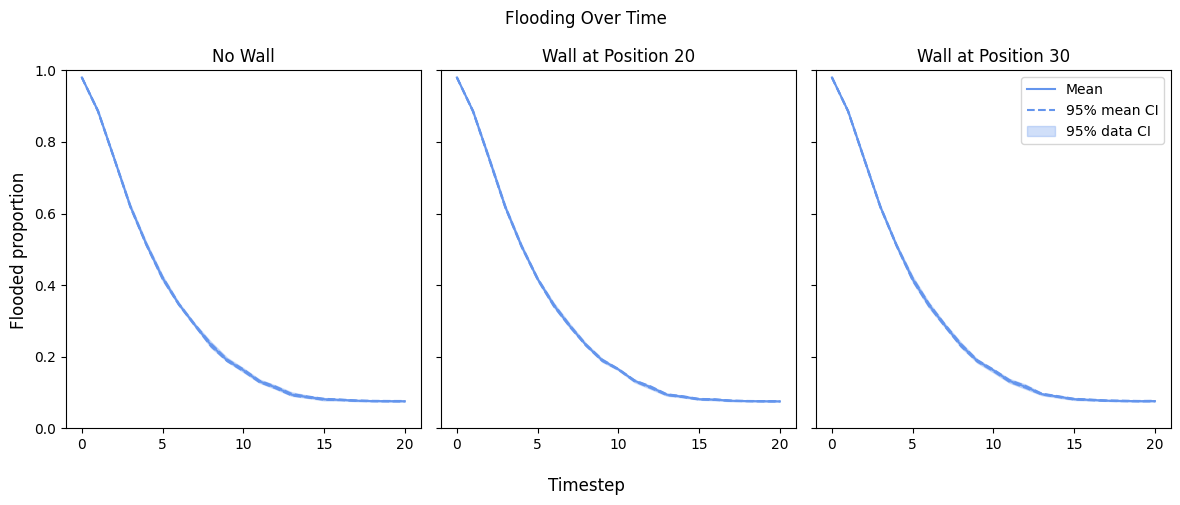

In [49]:
plot_wall_flooding_over_time(elevation_grid, wall_positions = [[[], []],[[0, 49], [20]], [[0, 49], [30]]])

In [50]:
def plot_wall_flooding_hist(elevation_map, wall_positions, trials = 10, steps = 20, infiltration_rate = 0.2, 
                  groundwater_rate = 0.2, infiltration_max = 5, min_flooded = 0):
    """
    Plot the flooded proportion distribution as a histogram for different wall positions.

    Parameters
    ----------
    elevation_map : numpy.ndarray
        Array of elevation values.
    wall_positions : list of tuples
        List of wall positions. Each tuple should contain the row and column ranges of the wall location.
    trials : int, optional
        Number of trials to run for each wall position. Default is 10.
    steps : int, optional
        Number of simulation steps to run for each trial. Default is 20.
    infiltration_rate : float, optional
        Rate at which water infiltrates into the soil. Default is 0.2.
    groundwater_rate : float, optional
        Rate at which water flows through the soil. Default is 0.2.
    infiltration_max : float, optional
        Maximum amount of water that can infiltrate into the soil per unit time. Default is 5.
    min_flooded : float, optional
        Minimum amount of flooding required to count a cell as flooded. Default is 0.

    Returns
    -------
    None
    """
    fig, ax = plt.subplots(1, 3, figsize = (12, 5), sharex = True, sharey = True)

    # plot each wall on different subplot
    for i, p in enumerate(wall_positions):

        flooding = []
        for _ in range(trials):

            sim = FloodingSimulation(dem = elevation_map, infiltration_rate = infiltration_rate, 
                                groundwater_rate = groundwater_rate, infiltration_max = infiltration_max, 
                                min_flooded = min_flooded, surpress_axis = True)
            
            # add wall and simulation rainfall
            sim.add_wall(p[0], p[1])
            sim.random_rain(1, sts.uniform(1, 1))

            for _ in range(steps):
                sim.update()      
            
            # correct for walls
            flooding.append(np.array(sim.flooded_over_time) - 1/50)

        # plot confidence intervals (data, mean) and mean
        ax[i].hist(np.array(flooding).flatten(), alpha = 0.9, label = 'Distribution', color = 'cornflowerblue')
        ax[i].axvline(np.quantile(flooding, 0.025), label = '95% data CI', color = 'orange')
        ax[i].axvline(np.quantile(flooding, 0.975), color = 'orange')
        ax[i].axvline((np.mean(flooding)-1.96*sts.sem(flooding))[0], label = '95% mean CI', color = 'black', linestyle = 'dashed')
        ax[i].axvline((np.mean(flooding)+1.96*sts.sem(flooding))[0])
        ax[i].axvline(np.mean(flooding), label = 'Mean', color = 'black')
        if len(p[1]) == 0:
            ax[i].set_title(f'No Wall')
        else:
            ax[i].set_title(f'Wall at Position {p[1][0]}')

    fig.suptitle('Flooding Distributions')
    fig.supxlabel('Flooding proportion')
    fig.supylabel('Frequency')
    fig.tight_layout()
    ax[2].legend()
    plt.show()

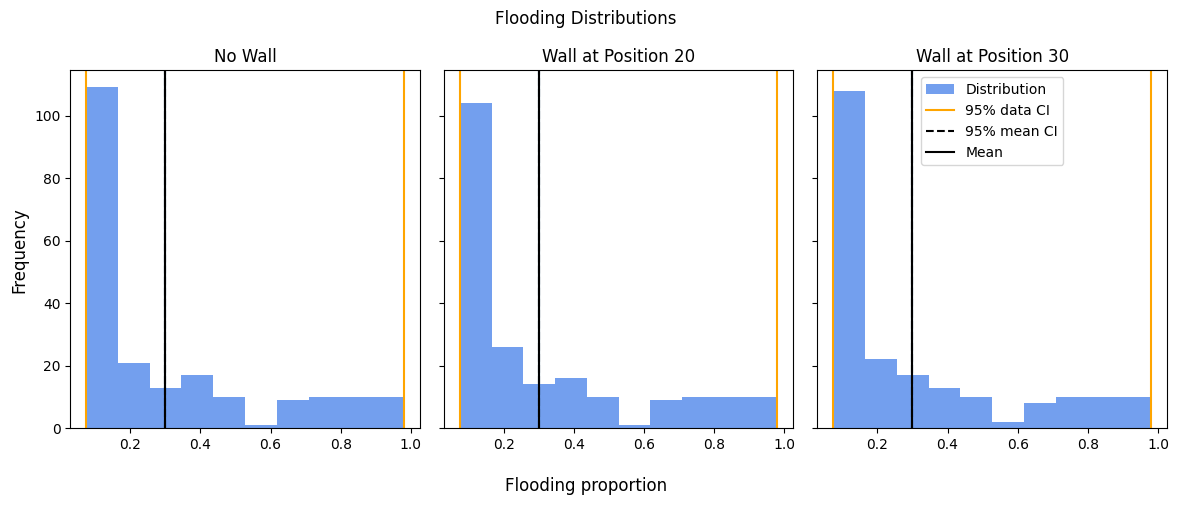

In [51]:
plot_wall_flooding_hist(elevation_grid, wall_positions = [[[], []],[[0, 49], [20]], [[0, 49], [30]]])